<a href="https://colab.research.google.com/github/iknyazeva/InverseProblem/blob/main/notebooks/about_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How we added noise to training data

In [1]:
!git clone https://github.com/iknyazeva/InverseProblem

Cloning into 'InverseProblem'...
remote: Enumerating objects: 629, done.
remote: Counting objects: 100% (629/629), done.
remote: Compressing objects: 100% (383/383), done.
remote: Total 629 (delta 453), reused 403 (delta 243), pack-reused 0
Receiving objects: 100% (629/629), 3.56 MiB | 12.97 MiB/s, done.
Resolving deltas: 100% (453/453), done.


In [3]:
cd InverseProblem

/content/InverseProblem


In [4]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd

from inverse_problem.milne_edington.me import *

In [5]:
fits_id = '1M0DJtpHfS_snqSshUiPfJc3IetlnHQXp'
gdd.download_file_from_google_drive(file_id=fits_id,
                                    dest_path='/content/line.fits', showsize=True)
# real profile
pth = '/content/line.fits'
line = fits.open(pth)[0].data

448.0 KiB Done.


In [6]:
def plot_lines(line, pix):
  plt.figure(figsize=(15,8))
  plt.subplot(2, 2, 1)
  plt.plot(line[0, pix, 56:], color='c')
  plt.title('Spectral line I')

  plt.subplot(2, 2, 2)
  plt.plot(line[1, pix, 56:], color='r')
  plt.title('Spectral line Q')

  plt.subplot(2, 2, 3)
  plt.plot(line[2, pix, 56:], color='y')
  plt.title('Spectral line U')

  plt.subplot(2, 2, 4)
  plt.plot(line[3, pix, 56:], color='m')
  plt.title('Spectral line V')

Looking through the data, you can see that the noise level of the spectra varies. For the components Q, U, V, this is even more obvious.

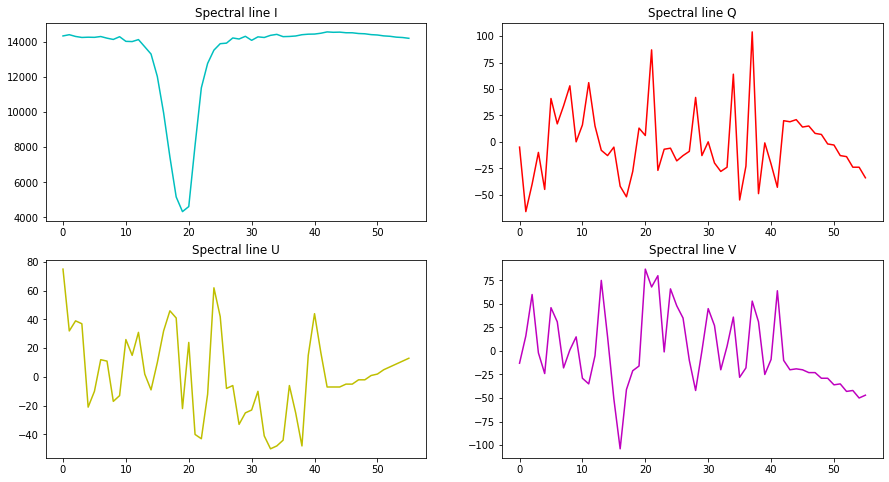

In [28]:
plot_lines(line, 0)

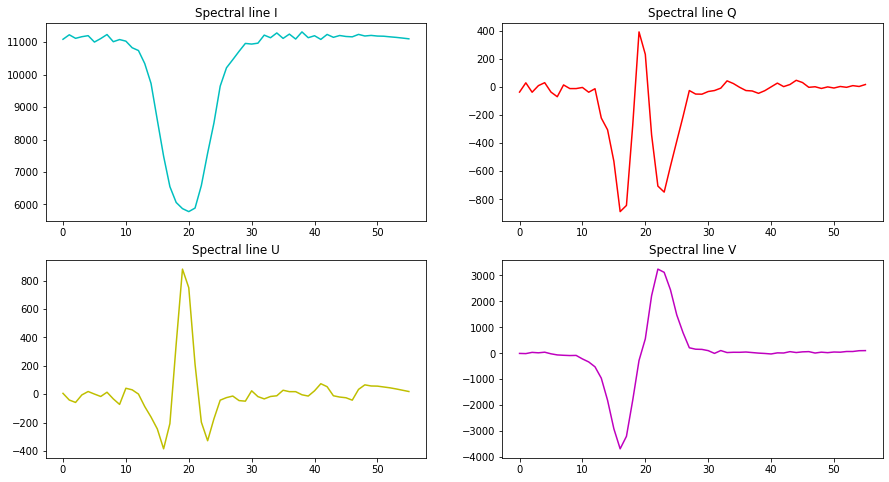

In [29]:
plot_lines(line, 329)

# For proper modeling, we need to understand how these noises are formed.



In reality, in addition to the useful signal, the receiver (the camera in this case) always collects some more "garbage" signal.
We can assumed that the volume of this "garbage" is always constant and does not depend on the incoming signal. The resulting spectrum will be the sum of the actual solar radiation and noise. When the spectrum is taken from the spot, there is less radiation and more noise will stand out in the resulting spectrum.

I, Q, U, V components are measured in pairs $$ (I + Q, I - Q), (I + U, I - U), (I + V, I - V)$$

In this case, $I$ is obtained by summing:

$$I = 0.5( (I + V) + (I - V))$$

And $Q, U, V$ by subtraction:

$$Q = 0.5( (I + Q) - (I - Q))$$

Because of this, one should expect that the noise level for different components will be different ($Q$ and $U$ are close in their physical meaning, so their noise may be the same).



# How to estimate the distribution of noise?




It is known from the Milne-Eddington model, that the parameters $Q, U, V$ should tend to zero as they move away from the center of the line. In this case, noise determines the value of the extreme pixels in the spectrum. We can collect statistics:

In [30]:
Q_noise = line[1, :, -1]
U_noise = line[2, :, -1]
V_noise = line[3, :, -1]

Text(0.5, 1.0, 'Distribution of noise')

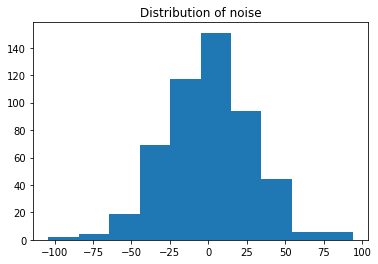

In [44]:
_ = plt.hist(Q_noise)
plt.title('Distribution of noise')

We see that the distribution looks like normal distribution.

Let's estimate the variance:

In [41]:
np.std(Q_noise)

28.096077793926035

In [33]:
np.std(U_noise)

25.089057379082586

In [34]:
np.std(V_noise)

38.76186735491266

# How to estimate noise for $I$?

В случае с I модельный профиль при удалении от линии стремится не к 0, а к интенсивности континуума. Просто брать крайние точки нельзя - в каждой помимо шумов прибавлен еще и разный сигнал. 

In the case of $I$, the model profile tends not to 0, but to the intensity of the continuum. We can't take extreme points - apart of noise, different signal is added in each point.

However, we can take the difference between the two nearest points:

In [35]:
I_noise = line[0, :, -1] - line[0, :, -2]

Text(0.5, 1.0, 'Distribution for noise of I component')

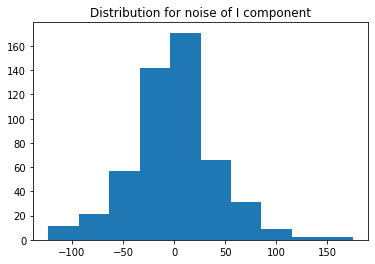

In [42]:
_= plt.hist(I_noise)
plt.title('Distribution for noise of I component')

The resulting value is the sum of two normally distributed values. In this case, the variance is:

In [37]:
np.std(I_noise)/np.sqrt(2)

23.046165864023987


We can adjust the estimation to reduce the effect of difference between two points:

In [39]:
I_noise = (line[0, :, -1] - line[0, :, -2]) + (line[0, :, -3] - line[0, :, -2])

In [40]:
np.std(I_noise)/np.sqrt(6)


16.518462188518853



# Continuum intensity



The intensity of the continuum corresponds to the value of the $I$ component far from the center of the line. It can be seen from the graph that this value is close to the maximum value of profile $I$.

In [13]:
def plot_lines_2(line):
  plt.figure(figsize=(15,8))
  plt.subplot(2, 2, 1)
  plt.plot(line[0, :, 0], color='c')
  plt.title('Spectral line I')

  plt.subplot(2, 2, 2)
  plt.plot(line[0, :, 1], color='r')
  plt.title('Spectral line Q')

  plt.subplot(2, 2, 3)
  plt.plot(line[0, :, 2], color='y')
  plt.title('Spectral line U')

  plt.subplot(2, 2, 4)
  plt.plot(line[0, :, 3], color='m')
  plt.title('Spectral line V')

In [21]:
l_v = [6302.5, 2.5, 1]
argument = np.linspace(6302.0692255, 6303.2544205, 56)
line_arg = 1000*(argument - 6302.5)
param_vec = np.array([500, 20, 20, 20, 1, 10, 10000, 10000, 0, 1, 0])

# compute profile with Milne-Eddington model
me_line = me_model(param_vec, line_arg, l_v, norm=False)

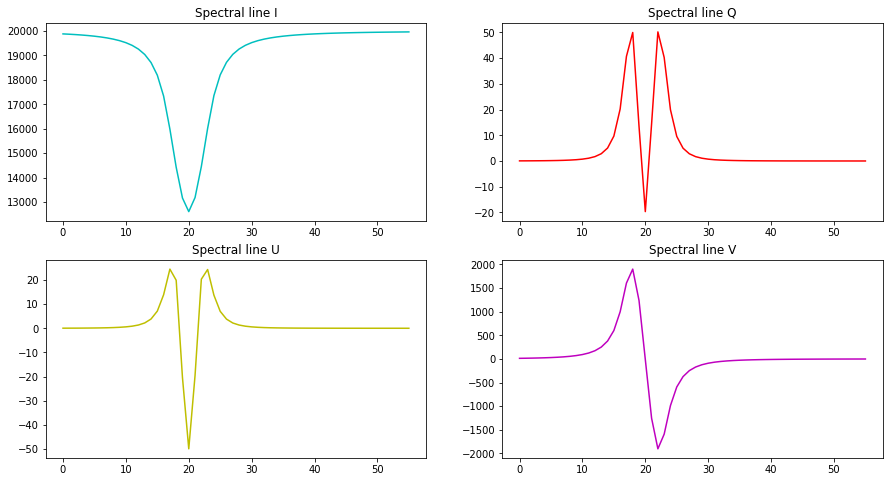

In [22]:
plot_lines_2(me_line)

In [24]:
cont = param_vec[6] + l_v[2] * param_vec[7]
cont

20000

In [26]:
np.max(me_line)

19960.38862072848

We send the continuum value calculated from parameters as input to the network during training. Continuum is equal to 20000 for this profile.

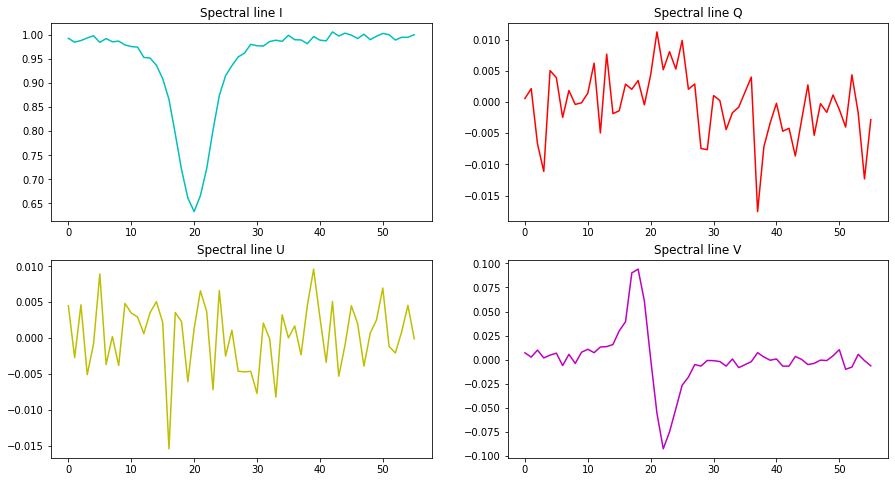

In [28]:
profile_noise = me_line + 100 * np.random.normal(size=me_line.shape)
training_profile = profile_noise / cont

plot_lines_2(training_profile)

In [29]:
np.max(training_profile)

1.0063624024543836

Now let's look at what happens to the same profile during inversion.

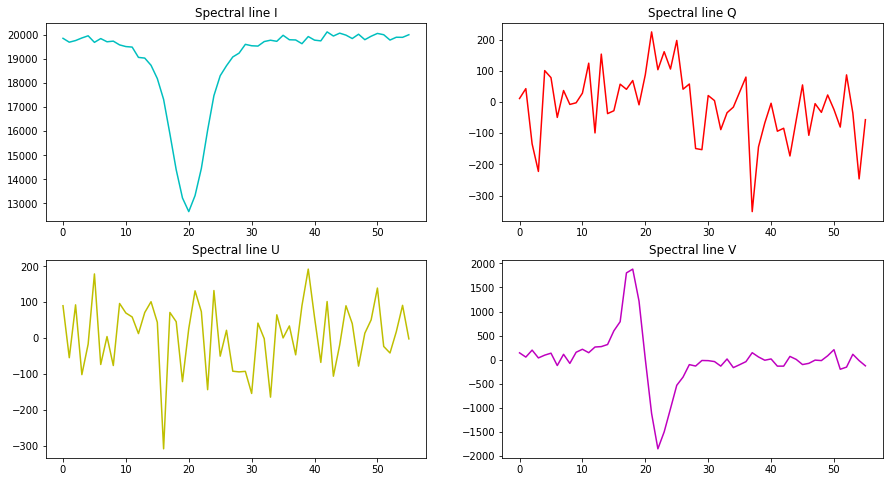

In [30]:
plot_lines_2(profile_noise)

During inversion the true intensity of the continuum is unknown to us, we take the maximum value of the profile instead of it.

In [32]:
inversion_cont = np.max(profile_noise)
inversion_cont

20127.24804908767

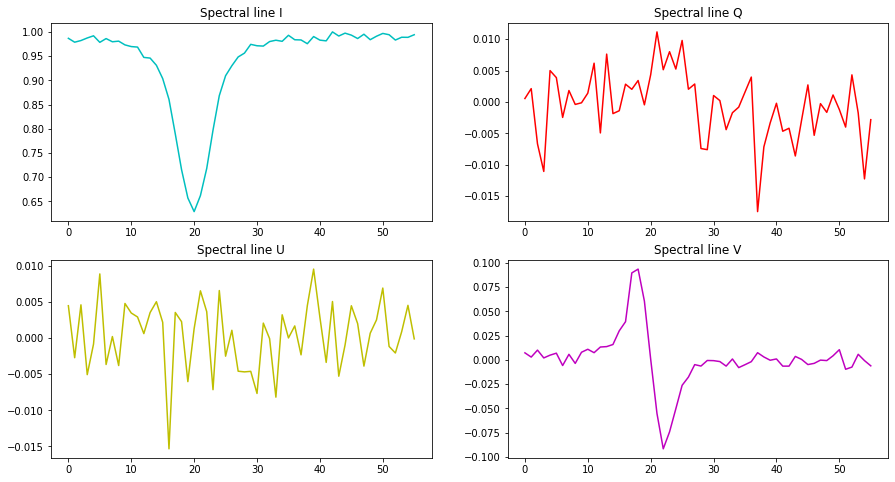

In [33]:
input_profile = profile_noise / inversion_cont

plot_lines_2(input_profile)

In [34]:
np.max(input_profile)

1.0

In both cases, we expect the same output from the network, but we supply different cont values and profiles that differ in scale at the input.